# Variational Autoencoder (VAE) using Keras

- [Original code](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

In [1]:
import numpy as np
from scipy.stats import norm
import time

# Load visualization library
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras import callbacks

Using TensorFlow backend.


In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

## Model construction

In [4]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

$\exp \frac{\log \sigma^{2}}{2} = \sigma$

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
z = Lambda(sampling)

In [7]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [8]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [9]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [10]:
vae = Model(x, x_decoded_mean)

## Model visualization

In [11]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514         dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 2)              514         dense_1[0][0]                    
___________________________________________________________________________________________

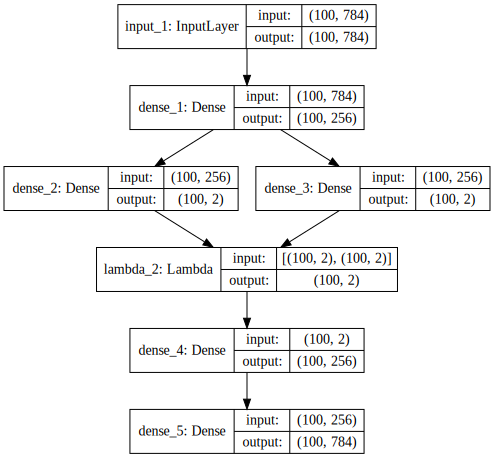

In [12]:
# Load modules for model visualization
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

# Model visualization
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

## Model compilation

In [13]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

## Model saving and loading

In [14]:
# Save

# Save the model in YAML format
yaml_string = vae.to_yaml()
open('./mnist_vae_model.yaml', 'w').write(yaml_string)

#　Save the initial weight
vae.save_weights('./mnist_vae_init_weight.hdf5', overwrite=True)

# Load

from keras.models import model_from_json, model_from_yaml

# Load the model saved in YAML format
#yaml_string = open('./mnist_mlp_model.yaml', 'r').read()
#model = model_from_yaml(yaml_string)

#model.load_weights('./mnist_mlp_init_weight.hdf5')

## Data loading

In [15]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [16]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Data visualization

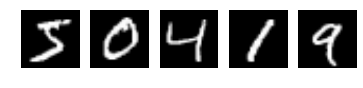

In [17]:
# Visualizing input data (the first 5 digits)
fig, ax = plt.subplots(1, 5)

for ii in range(5):
    ax[ii].imshow(x_train[ii].reshape(28, 28), cmap='gray')
    ax[ii].axis('off')

## Model training

- tensorboard --logdir=/tmp/keras_mnist_vae
- http://0.0.0.0:6006

In [18]:
# Use TensorBoard for checking the progress
tb_cb = callbacks.TensorBoard(log_dir='/tmp/keras_mnist_vae', histogram_freq=0)

# Save model when the validation loss goes down after each epoch
cp_cb = callbacks.ModelCheckpoint(filepath='./mnist_vae_best_weight.hdf5', 
                                        monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Stop training when the validation loss goes up in the past 5 consecutive epochs
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [19]:
tic = time.time()

history = vae.fit(x_train, x_train,
                  shuffle=True,
                  batch_size=batch_size,
                  nb_epoch=nb_epoch,
                  validation_data=(x_test, x_test),
                  verbose=True,
                  callbacks=cbks)

toc = time.time()

# Show the total training time
print("Training time: {0:.2f} [sec]".format(toc - tic))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s - loss: 189.8317 - val_loss: 172.1817
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 169.6328 - val_loss: 167.9567
Epoch 3/50
60000/60000 [==============================] - 6s - loss: 166.6389 - val_loss: 165.6747
Epoch 4/50
60000/60000 [==============================] - 6s - loss: 164.6240 - val_loss: 163.9406
Epoch 5/50
60000/60000 [==============================] - 6s - loss: 163.1607 - val_loss: 162.5379
Epoch 6/50
60000/60000 [==============================] - 6s - loss: 161.9992 - val_loss: 161.7577
Epoch 7/50
60000/60000 [==============================] - 6s - loss: 160.9884 - val_loss: 161.0425
Epoch 8/50
60000/60000 [==============================] - 8s - loss: 160.0518 - val_loss: 159.9991
Epoch 9/50
60000/60000 [==============================] - 6s - loss: 159.1695 - val_loss: 159.0140
Epoch 10/50
60000/60000 [==============================] - 

## Load the best parameter

In [20]:
vae.load_weights('./mnist_vae_best_weight.hdf5')

## Evaluation of the results

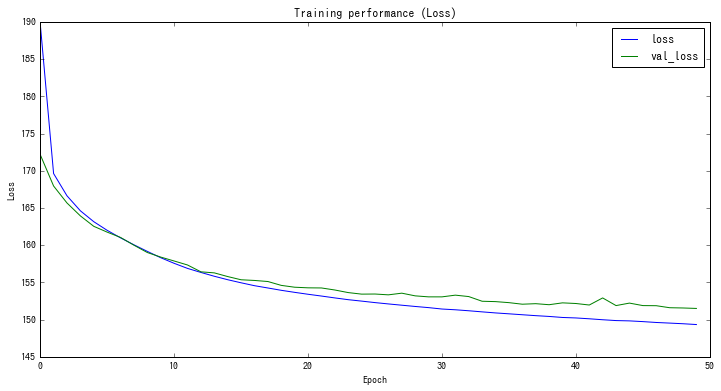

In [21]:
# 学習曲線
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Training performance (Loss)')
ax.plot(history.epoch, history.history['loss'], label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val_loss')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

#ax[1].set_title('Training performance (Accuracy)')
#ax[1].plot(history.epoch, history.history['acc'], label='acc')
#ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
#ax[1].set(xlabel='Epoch', ylabel='Accuracy')
#ax[1].legend(loc='best')

In [22]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [23]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

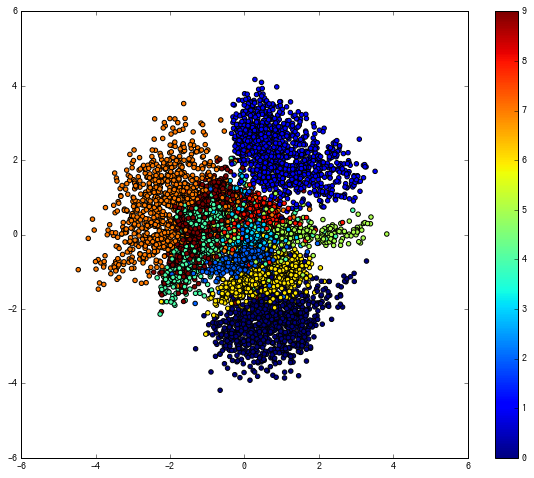

In [24]:
plt.figure(figsize=(10, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [25]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [26]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [27]:
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [28]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

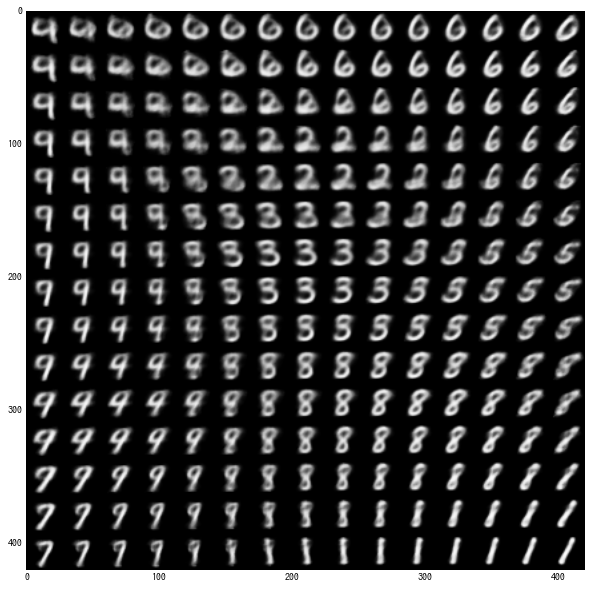

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [30]:
from ipywidgets import interact, interactive, fixed, widgets

In [31]:
def f(z1, z2):
    z_sample = np.array([[z1, z2]])
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    plt.imshow(digit, 'gray')
    plt.draw()

<function __main__.f>

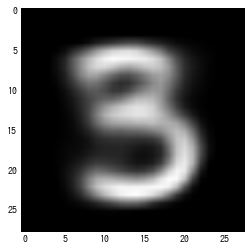

In [33]:
interact(f, z1=(-5., 5., 0.1), z2=(-5., 5., 0.1))